## Recluster
Take the GMM (spherical) clustering with smoothing, and merge the clusters together again and recluster them, now using the atom coordinates, not only the residues.

In [1]:
import sys
import numpy as np
sys.path.append('/home/vit/Projects/cryptoshow-analysis/src')
import cryptoshow_utils

def get_atom_coordinates(pdb_id, chain_id, residue_ids, auth=True):
    import biotite.database.rcsb as rcsb
    import biotite.structure.io.pdbx as pdbx
    from biotite.structure.io.pdbx import get_structure
    
    cif_file_path = rcsb.fetch(pdb_id, "cif", cryptoshow_utils.CIF_FILES_PATH)
    cif_file = pdbx.CIFFile.read(cif_file_path)
    
    protein = get_structure(cif_file, model=1, use_author_fields=auth, extra_fields=["atom_id"])
    protein = protein[(protein.chain_id == chain_id) & (np.isin(protein.res_id, residue_ids))]
    
    coords = protein.coord
    atom_to_residue_ids = protein.res_id
    atom_ids = protein.atom_id

    return coords, atom_ids, atom_to_residue_ids

In [ ]:
import sys
import pymol
_stdouterr = sys.stdout, sys.stderr
pymol.finish_launching(['/usr/bin/pymol', '-q'])
sys.stdout, sys.stderr = _stdouterr
from sklearn.mixture import BayesianGaussianMixture

# load something into the PyMOL window
from pymol import cmd
import sys
import numpy as np
from sklearn.mixture import BayesianGaussianMixture
sys.path.append('/home/vit/Projects/cryptoshow-analysis/src/B-evaluate-cryptoshow')
sys.path.append('/home/vit/Projects/cryptoshow-analysis/src/D-visualize')
sys.path.append('/home/vit/Projects/cryptoshow-analysis/src')
import eval_utils
import cryptoshow_utils
import vis_utils

CBS_DATA_PATH = '/home/vit/Projects/cryptoshow-analysis/data/A-cluster-ligysis-data/cryptobench-clustered-binding-sites.txt'
PREDICTIONS_PATH = '/home/vit/Projects/cryptoshow-analysis/data/D-visualize/predictions'

# load ground truth binding residues: these have mmcif numbering and need to be mapped to auth labeling
binding_residues_mmcifed, _ = eval_utils.read_test_binding_residues(data_path=CBS_DATA_PATH)
binding_residues_mmcifed = vis_utils.reformat_binding_residues(binding_residues_mmcifed)

# load predictions
model_predictions_mmcifed = vis_utils.read_predictions(data_path=f'{PREDICTIONS_PATH}/GMMspherical-finetuning-with-smoothing', protein_ids=binding_residues_mmcifed.keys())
model_predictions_mmcifed = {protein_id: [[pocket] for pocket, _ in pockets] for protein_id, pockets in model_predictions_mmcifed.items()}
# map binding residues to auth labeling
model_predictions = {protein_id: [cryptoshow_utils.map_mmcif_numbering_to_auth(protein_id[:4], protein_id[4:], pocket[0]) for pocket in pockets] for protein_id, pockets in model_predictions_mmcifed.items()}
binding_residues = {protein_id: [cryptoshow_utils.map_mmcif_numbering_to_auth(protein_id[:4], protein_id[4:], pocket) for pocket in pockets] for protein_id, pockets in binding_residues_mmcifed.items()}

Gtk-Message: 13:49:48.744: Failed to load module "pk-gtk-module"
Cannot open file '/home/vit/Projects/cryptoshow-analysis/src/F-clustering/data/pymol/icons/icon2.svg', because: No such file or directory
Cannot open file '/home/vit/Projects/cryptoshow-analysis/src/F-clustering/data/pymol/icons/icon2.svg', because: No such file or directory


Could not read PyMOL stylesheet.
DEBUG: PYMOL_DATA='./data'
 Detected OpenGL version 4.6. Shaders available.
 Geometry shaders not available
 Detected GLSL version 4.60.
PyMOL>set fetch_path, /home/vit/Projects/ahoj2-extraction/src/analysis/cif_files
 Setting: fetch_path set to /home/vit/Projects/ahoj2-extraction/src/analysis/cif_files.


## Try GMM

In [ ]:
COLORS = ['pink', 'red', 'blue', 'green', 'brown', 'forest', 'sand', 'skyblue', 'slate', 'smudge', 'splitpea', 'sulfur', 'teal', 'tv_blue', 'tv_green', 'tv_orange', 'tv_red', 'tv_yellow']
CIF_FILES = '/home/vit/Projects/deeplife-project/data/cif_files'

for protein_id in binding_residues.keys():
    binding_sites = model_predictions[protein_id]
    merged_binding_sites = np.concatenate(binding_sites)

    coords, atom_ids, atom_to_residue_ids = get_atom_coordinates(protein_id[:4], protein_id[4:], merged_binding_sites)
    
    bgmm = BayesianGaussianMixture(
        n_components=len(atom_ids), 
        random_state=42,
        covariance_type='spherical',
        weight_concentration_prior=1e-15,
        degrees_of_freedom_prior=35

    )   

    bgmm.fit(coords)    

    active_clusters = sum(bgmm.weights_ > 0.1)
    print('Active clusters:', active_clusters)
    bgmm = BayesianGaussianMixture(
        n_components=max(active_clusters, 1),
        random_state=42,
        covariance_type='spherical',
        degrees_of_freedom_prior=35
    )

    bgmm.fit(coords)
    labels = bgmm.predict(coords)   

    cmd.reinitialize()
    cmd.set('fetch_path', cmd.exp_path(CIF_FILES), quiet=0)
    cmd.fetch(protein_id)
    cmd.zoom(protein_id)
    cmd.color('grey', protein_id)
    

    final_predicted_binding_sites = [[] for _ in range(np.max(labels) + 1)]
    for atom_index, cluster_label in zip(atom_ids, labels):
        final_predicted_binding_sites[cluster_label].append(atom_index)

    for i, pocket in enumerate(final_predicted_binding_sites):
        cmd.color(COLORS[i % len(COLORS)], vis_utils.generate_pymol_algebra_selection(protein_id, pocket, are_atom_ids=True))

    DCCs = vis_utils.compute_DCCs(protein_id, binding_residues_mmcifed[protein_id], model_predictions_mmcifed[protein_id])
    successful_predictions = vis_utils.count_successful_predictions(DCCs)
    print(f'{successful_predictions} / {len(binding_residues_mmcifed[protein_id])} pockets found. {DCCs}')
    
    cmd.show('surface', protein_id)
    cmd.zoom(protein_id)
    user_input = input(">Press Enter for the next protein (press 'q' to quit)...\n")
    if user_input.lower() == 'q':
        break

/home/vit/.local/lib/python3.11/site-packages/sklearn/mixture/_base.py:270: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(
/home/vit/.local/lib/python3.11/site-packages/sklearn/mixture/_base.py:270: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Active clusters: 2
 Setting: fetch_path set to /home/vit/Projects/deeplife-project/data/cif_files.
 ExecutiveLoad-Detail: Detected mmCIF
120.15907
107.33309
0 / 1 pockets found. [107.33309]
Active clusters: 3
 Setting: fetch_path set to /home/vit/Projects/deeplife-project/data/cif_files.
 ExecutiveLoad-Detail: Detected mmCIF
71.90925
0 / 1 pockets found. [71.90925]
Active clusters: 0
 Setting: fetch_path set to /home/vit/Projects/deeplife-project/data/cif_files.
 ExecutiveLoad-Detail: Detected mmCIF
69.553734
52.473698
55.447197
0 / 1 pockets found. [52.473698]
Active clusters: 2
 Setting: fetch_path set to /home/vit/Projects/deeplife-project/data/cif_files.
 ExecutiveLoad-Detail: Detected mmCIF
39.831264
28.843555
38.4126
41.04201
0 / 1 pockets found. [28.843555]
Active clusters: 2
 Setting: fetch_path set to /home/vit/Projects/deeplife-project/data/cif_files.
 ExecutiveLoad-Detail: Detected mmCIF
38.173637
65.48174
0 / 1 pockets found. [38.173637]


/home/vit/.local/lib/python3.11/site-packages/sklearn/mixture/_base.py:270: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Active clusters: 3
 Setting: fetch_path set to /home/vit/Projects/deeplife-project/data/cif_files.
 ExecutiveLoad-Detail: Detected mmCIF
77.46249
41.193623
0 / 1 pockets found. [41.193623]
Active clusters: 1
 Setting: fetch_path set to /home/vit/Projects/deeplife-project/data/cif_files.
 ExecutiveLoad-Detail: Detected mmCIF
41.391994
75.576195
0 / 1 pockets found. [41.391994]


ValueError: need at least one array to concatenate

## Try other clustering methods

#### NOTES:
DBScan again no good.

#### agglomerativeClustering
kind of works, but sometimes it is random. If the threshold is too low (3.5) then there are these 'alone' residues sometimes, which do not make sense. On the other hand, if the eps is too high (5.0) then there are "pockets" which are all over the whole protein and don't make sense. (1kxrA). If nothing else, the 4.5A threshold is bearable.


In [14]:
COLORS = ['pink', 'red', 'blue', 'green', 'brown', 'forest', 'sand', 'skyblue', 'slate', 'smudge', 'splitpea', 'sulfur', 'teal', 'tv_blue', 'tv_green', 'tv_orange', 'tv_red', 'tv_yellow']
CIF_FILES = '/home/vit/Projects/deeplife-project/data/cif_files'

from sklearn.cluster import AgglomerativeClustering
eps = 4.5


for protein_id in binding_residues.keys():
    binding_sites = model_predictions[protein_id]
    if len(binding_sites) == 0:
        continue
    merged_binding_sites = np.concatenate(binding_sites)
    coords, atom_ids, atom_to_residue_ids = get_atom_coordinates(protein_id[:4], protein_id[4:], merged_binding_sites)
    
    clustering = AgglomerativeClustering(distance_threshold=eps, n_clusters=None, linkage='single')

    labels = clustering.fit_predict(coords)   

    cmd.reinitialize()

    cmd.set('fetch_path', cmd.exp_path(CIF_FILES), quiet=0)
    cmd.fetch(protein_id)
    cmd.zoom(protein_id)
    cmd.color('grey', protein_id)
    

    final_predicted_binding_sites = [[] for _ in range(np.max(labels) + 1)]
    for atom_index, cluster_label in zip(atom_ids, labels):
        final_predicted_binding_sites[cluster_label].append(atom_index)

    for i, pocket in enumerate(final_predicted_binding_sites):
        cmd.color(COLORS[i % len(COLORS)], vis_utils.generate_pymol_algebra_selection(protein_id, pocket, are_atom_ids=True))

    DCCs = vis_utils.compute_DCCs(protein_id, binding_residues_mmcifed[protein_id], model_predictions_mmcifed[protein_id])
    successful_predictions = vis_utils.count_successful_predictions(DCCs)
    print(f'{successful_predictions} / {len(binding_residues_mmcifed[protein_id])} pockets found. {DCCs}')
    
    actual_binding_sites = np.concatenate(binding_residues[protein_id])
    cmd.set('transparency', 0.5, vis_utils.generate_pymol_algebra_selection(protein_id, actual_binding_sites, are_atom_ids=False))

    cmd.show('surface', protein_id)
    cmd.zoom(protein_id)
    user_input = input(">Press Enter for the next protein (press 'q' to quit)...\n")
    if user_input.lower() == 'q':
        break

 Setting: fetch_path set to /home/vit/Projects/deeplife-project/data/cif_files.
 ExecutiveLoad-Detail: Detected mmCIF
120.15907
107.33309
0 / 1 pockets found. [107.33309]
 Setting: fetch_path set to /home/vit/Projects/deeplife-project/data/cif_files.
 ExecutiveLoad-Detail: Detected mmCIF
71.90925
0 / 1 pockets found. [71.90925]
 Setting: fetch_path set to /home/vit/Projects/deeplife-project/data/cif_files.
 ExecutiveLoad-Detail: Detected mmCIF
69.553734
52.473698
55.447197
0 / 1 pockets found. [52.473698]
 Setting: fetch_path set to /home/vit/Projects/deeplife-project/data/cif_files.
 ExecutiveLoad-Detail: Detected mmCIF
39.831264
28.843555
38.4126
41.04201
0 / 1 pockets found. [28.843555]
 Setting: fetch_path set to /home/vit/Projects/deeplife-project/data/cif_files.
 ExecutiveLoad-Detail: Detected mmCIF
38.173637
65.48174
0 / 1 pockets found. [38.173637]
 Setting: fetch_path set to /home/vit/Projects/deeplife-project/data/cif_files.
 ExecutiveLoad-Detail: Detected mmCIF
77.46249
41.1

## Compare with residue-level GMM

In [ ]:
COLORS = ['pink', 'red', 'blue', 'green', 'brown', 'forest', 'sand', 'skyblue', 'slate', 'smudge', 'splitpea', 'sulfur', 'teal', 'tv_blue', 'tv_green', 'tv_orange', 'tv_red', 'tv_yellow']
CIF_FILES = '/home/vit/Projects/deeplife-project/data/cif_files'

COORDINATES_DIR = '/home/vit/Projects/cryptoshow-analysis/data/A-cluster-ligysis-data/coordinates'

for protein_id in binding_residues.keys():
    binding_sites = model_predictions[protein_id]
    if len(binding_sites) == 0:
        continue
    
    merged_binding_sites_mmcifed = [pocket[0] for pocket in model_predictions_mmcifed[protein_id]]
    merged_binding_sites_mmcifed = np.concatenate(merged_binding_sites_mmcifed)
    merged_binding_sites_auth = np.concatenate(model_predictions[protein_id])

    coords = np.load(f'{COORDINATES_DIR}/{protein_id}.npy')
    binding_site_coords = coords[merged_binding_sites_mmcifed]

    bgmm = BayesianGaussianMixture(
        n_components=len(merged_binding_sites_auth), 
        random_state=42,
        covariance_type='spherical',
        weight_concentration_prior=1e-15,
    )   

    bgmm.fit(binding_site_coords)    

    active_clusters = sum(bgmm.weights_ > 0.1)

    bgmm = BayesianGaussianMixture(
        n_components=max(active_clusters, 1), 
        random_state=42,
        covariance_type='spherical',
        weight_concentration_prior=1e-15,
    )

    labels = bgmm.fit_predict(binding_site_coords)   

    cmd.reinitialize()
    cmd.set('fetch_path', cmd.exp_path(CIF_FILES), quiet=0)
    cmd.fetch(protein_id)
    cmd.zoom(protein_id)
    cmd.color('grey', protein_id)
    

    final_predicted_binding_sites = [[] for _ in range(np.max(labels) + 1)]
    for residue_index, cluster_label in zip(merged_binding_sites_auth, labels):
        final_predicted_binding_sites[cluster_label].append(residue_index)

    for i, pocket in enumerate(final_predicted_binding_sites):
        if len(pocket) == 0:
            continue
        cmd.color(COLORS[i % len(COLORS)], vis_utils.generate_pymol_algebra_selection(protein_id, pocket))

    DCCs = vis_utils.compute_DCCs(protein_id, binding_residues_mmcifed[protein_id], model_predictions_mmcifed[protein_id])
    successful_predictions = vis_utils.count_successful_predictions(DCCs)
    print(f'{successful_predictions} / {len(binding_residues_mmcifed[protein_id])} pockets found. {DCCs}')
    
    cmd.show('surface', protein_id)
    cmd.zoom(protein_id)
    user_input = input(">Press Enter for the next protein (press 'q' to quit)...\n")
    if user_input.lower() == 'q':
        break

## GMM with embedding reducted vectors

In [88]:
COLORS = ['pink', 'red', 'blue', 'green', 'brown', 'forest', 'sand', 'skyblue', 'slate', 'smudge', 'splitpea', 'sulfur', 'teal', 'tv_blue', 'tv_green', 'tv_orange', 'tv_red', 'tv_yellow']
CIF_FILES = '/home/vit/Projects/deeplife-project/data/cif_files'
    
COORDINATES_DIR = '/home/vit/Projects/cryptoshow-analysis/data/A-cluster-ligysis-data/coordinates'
EMBEDDINGS_DIR = '/home/vit/Projects/cryptoshow-analysis/data/B-evaluate-cryptoshow/embeddings'

skip = True
for protein_id in binding_residues.keys():
    if skip and protein_id == '1kxrA':
        skip = False
    if skip:
        continue
    

    binding_sites = model_predictions[protein_id]
    if len(binding_sites) == 0:
        continue
    
    merged_binding_sites_mmcifed = [pocket[0] for pocket in model_predictions_mmcifed[protein_id]]
    merged_binding_sites_mmcifed = np.concatenate(merged_binding_sites_mmcifed)
    merged_binding_sites_auth = np.concatenate(model_predictions[protein_id])

    coords = np.load(f'{COORDINATES_DIR}/{protein_id}.npy')
    embeddings = np.load(f'{EMBEDDINGS_DIR}/{protein_id}.npy')

    assert coords.shape[0] == embeddings.shape[0], "Coordinates and embeddings must have the same number of atoms."

    binding_site_coords = coords[merged_binding_sites_mmcifed]
    binding_site_embeddings = embeddings[merged_binding_sites_mmcifed]

    from sklearn.decomposition import PCA

    pca = PCA(n_components=min(7, binding_site_embeddings.shape[0]), random_state=42)
    projections = pca.fit_transform(binding_site_embeddings)

    concatenated_features = np.concatenate((projections, binding_site_coords), axis=1)

    bgmm = BayesianGaussianMixture(
        n_components=len(concatenated_features), 
        random_state=42,
        covariance_type='spherical',
        weight_concentration_prior=1e-15,
    )   

    bgmm.fit(concatenated_features)    

    active_clusters = sum(bgmm.weights_ > 0.1)

    bgmm = BayesianGaussianMixture(
        n_components=max(active_clusters, 1), 
        random_state=42,
        covariance_type='spherical',
        weight_concentration_prior=1e-15,
    )

    labels = bgmm.fit_predict(concatenated_features)   

    cmd.reinitialize()
    cmd.set('fetch_path', cmd.exp_path(CIF_FILES), quiet=0)
    cmd.fetch(protein_id)
    cmd.zoom(protein_id)
    cmd.color('grey', protein_id)
    

    final_predicted_binding_sites = [[] for _ in range(np.max(labels) + 1)]
    for residue_index, cluster_label in zip(merged_binding_sites_auth, labels):
        final_predicted_binding_sites[cluster_label].append(residue_index)

    for i, pocket in enumerate(final_predicted_binding_sites):
        if len(pocket) == 0:
            continue
        cmd.color(COLORS[i % len(COLORS)], vis_utils.generate_pymol_algebra_selection(protein_id, pocket))

    DCCs = vis_utils.compute_DCCs(protein_id, binding_residues_mmcifed[protein_id], model_predictions_mmcifed[protein_id])
    successful_predictions = vis_utils.count_successful_predictions(DCCs)
    print(f'{successful_predictions} / {len(binding_residues_mmcifed[protein_id])} pockets found. {DCCs}')
    
    actual_binding_sites = np.concatenate(binding_residues[protein_id])
    cmd.set('transparency', 0.5, vis_utils.generate_pymol_algebra_selection(protein_id, actual_binding_sites, are_atom_ids=False))


    cmd.show('surface', protein_id)
    cmd.zoom(protein_id)
    user_input = input(">Press Enter for the next protein (press 'q' to quit)...\n")
    if user_input.lower() == 'q':
        break

/home/vit/.local/lib/python3.11/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (44) found smaller than n_clusters (52). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


 Setting: fetch_path set to /home/vit/Projects/deeplife-project/data/cif_files.
 ExecutiveLoad-Detail: Detected mmCIF
38.218395
81.082664
45.914783
0 / 1 pockets found. [38.218395]


In [ ]:
COLORS = ['pink', 'red', 'blue', 'green', 'brown', 'forest', 'sand', 'skyblue', 'slate', 'smudge', 'splitpea', 'sulfur', 'teal', 'tv_blue', 'tv_green', 'tv_orange', 'tv_red', 'tv_yellow']
CIF_FILES = '/home/vit/Projects/deeplife-project/data/cif_files'
    
COORDINATES_DIR = '/home/vit/Projects/cryptoshow-analysis/data/A-cluster-ligysis-data/coordinates'
EMBEDDINGS_DIR = '/home/vit/Projects/cryptoshow-analysis/data/B-evaluate-cryptoshow/embeddings'

# 5b0eB - two binding sites merged together
# 3n4uA - this is random
# 5wbmB - totally random
# 3v55A - two binding sites merged together
# 3idhA - two binding sites merged together
# 5uxaA - same as 3n4uA I guess
eps = 12
skip = True

for protein_id in binding_residues.keys():
    if skip and protein_id == '5uxaA':
        skip = False
    if skip:
        continue
    
    binding_sites = model_predictions[protein_id]
    if len(binding_sites) == 0:
        continue
    
    merged_binding_sites_mmcifed = [pocket[0] for pocket in model_predictions_mmcifed[protein_id]]
    merged_binding_sites_mmcifed = np.concatenate(merged_binding_sites_mmcifed)
    merged_binding_sites_auth = np.concatenate(model_predictions[protein_id])

    assert len(merged_binding_sites_auth) == len(merged_binding_sites_mmcifed)

    coords = np.load(f'{COORDINATES_DIR}/{protein_id}.npy')
    embeddings = np.load(f'{EMBEDDINGS_DIR}/{protein_id}.npy')

    if coords.shape[0] != embeddings.shape[0]:
        continue

    binding_site_coords = coords[merged_binding_sites_mmcifed]
    binding_site_embeddings = embeddings[merged_binding_sites_mmcifed]

    from sklearn.decomposition import PCA

    pca = PCA(n_components=min(10, binding_site_embeddings.shape[0]), random_state=42)
    projections = pca.fit_transform(binding_site_embeddings)

    concatenated_features = np.concatenate((projections, binding_site_coords), axis=1)

    from sklearn.cluster import AgglomerativeClustering
    clustering = AgglomerativeClustering(distance_threshold=eps, n_clusters=None, linkage='single')
    labels = clustering.fit_predict(concatenated_features)


    cmd.reinitialize()
    cmd.set('fetch_path', cmd.exp_path(CIF_FILES), quiet=0)
    cmd.fetch(protein_id)
    cmd.zoom(protein_id)
    cmd.color('grey', protein_id)
    

    final_predicted_binding_sites = [[] for _ in range(np.max(labels) + 1)]
    for residue_index, cluster_label in zip(merged_binding_sites_auth, labels):
        final_predicted_binding_sites[cluster_label].append(residue_index)

    for i, pocket in enumerate(final_predicted_binding_sites):
        if len(pocket) == 0:
            continue
        cmd.color(COLORS[i % len(COLORS)], vis_utils.generate_pymol_algebra_selection(protein_id, pocket))

    DCCs = vis_utils.compute_DCCs(protein_id, binding_residues_mmcifed[protein_id], model_predictions_mmcifed[protein_id])
    successful_predictions = vis_utils.count_successful_predictions(DCCs)
    print(f'{successful_predictions} / {len(binding_residues_mmcifed[protein_id])} pockets found. {DCCs}')
    
    actual_binding_sites = np.concatenate(binding_residues[protein_id])
    cmd.set('transparency', 0.5, vis_utils.generate_pymol_algebra_selection(protein_id, actual_binding_sites, are_atom_ids=False))


    cmd.show('surface', protein_id)
    cmd.zoom(protein_id)
    user_input = input(">Press Enter for the next protein (press 'q' to quit)...\n")
    if user_input.lower() == 'q':
        break

 Setting: fetch_path set to /home/vit/Projects/deeplife-project/data/cif_files.
 ExecutiveLoad-Detail: Detected mmCIF
38.173637
65.48174
0 / 1 pockets found. [38.173637]
 Setting: fetch_path set to /home/vit/Projects/deeplife-project/data/cif_files.
 ExecutiveLoad-Detail: Detected mmCIF
77.46249
41.193623
0 / 1 pockets found. [41.193623]
 Setting: fetch_path set to /home/vit/Projects/deeplife-project/data/cif_files.
 ExecutiveLoad-Detail: Detected mmCIF
41.391994
75.576195
0 / 1 pockets found. [41.391994]
 Setting: fetch_path set to /home/vit/Projects/deeplife-project/data/cif_files.
 ExecutiveLoad-Detail: Detected mmCIF
74.19856
0 / 1 pockets found. [74.19856]
 Setting: fetch_path set to /home/vit/Projects/deeplife-project/data/cif_files.
 ExecutiveLoad-Detail: Detected mmCIF
90.59458
75.23491
0 / 1 pockets found. [75.23491]
 Setting: fetch_path set to /home/vit/Projects/deeplife-project/data/cif_files.
 ExecutiveLoad-Detail: Detected mmCIF
67.054184
47.952244
81.64181
60.029034
0 / 2

#### PCA-ed embeddings + coordinates + Agglomerative clustering + postprocessing merging 
TODO

In [ ]:
import numpy as np
from scipy.spatial.distance import cdist
from scipy.sparse.csgraph import connected_components


COLORS = ['pink', 'red', 'blue', 'green', 'brown', 'forest', 'sand', 'skyblue', 'slate', 'smudge', 'splitpea', 'sulfur', 'teal', 'tv_blue', 'tv_green', 'tv_orange', 'tv_red', 'tv_yellow']
CIF_FILES = '/home/vit/Projects/deeplife-project/data/cif_files'
    
COORDINATES_DIR = '/home/vit/Projects/cryptoshow-analysis/data/A-cluster-ligysis-data/coordinates'
EMBEDDINGS_DIR = '/home/vit/Projects/cryptoshow-analysis/data/B-evaluate-cryptoshow/embeddings'

# 5b0eB - two binding sites merged together
# 3n4uA - this is random
# 5wbmB - totally random
# 3v55A - two binding sites merged together
# 3idhA - two binding sites merged together
# 5uxaA - same as 3n4uA I guess

eps = 13
skip = True

for protein_id in binding_residues.keys():
    # if skip and protein_id == '5b0eB':
    #     skip = False
    # if skip:
    #     continue
    # if protein_id not in ['5b0eB', '3n4uA', '5wbmB', '3v55A', '3idhA', '5uxaA']:
    #     continue

    binding_sites = model_predictions[protein_id]
    if len(binding_sites) == 0:
        continue
    
    merged_binding_sites_mmcifed = [pocket[0] for pocket in model_predictions_mmcifed[protein_id]]
    merged_binding_sites_mmcifed = np.concatenate(merged_binding_sites_mmcifed)
    merged_binding_sites_auth = np.concatenate(model_predictions[protein_id])

    assert len(merged_binding_sites_auth) == len(merged_binding_sites_mmcifed)

    coords = np.load(f'{COORDINATES_DIR}/{protein_id}.npy')
    embeddings = np.load(f'{EMBEDDINGS_DIR}/{protein_id}.npy')

    if coords.shape[0] != embeddings.shape[0]:
        continue

    binding_site_coords = coords[merged_binding_sites_mmcifed]
    binding_site_embeddings = embeddings[merged_binding_sites_mmcifed]

    from sklearn.decomposition import PCA

    pca = PCA(n_components=min(1, binding_site_embeddings.shape[0]), random_state=42)
    projections = pca.fit_transform(binding_site_embeddings)

    concatenated_features = np.concatenate((projections, binding_site_coords), axis=1)

    from sklearn.cluster import AgglomerativeClustering
    clustering = AgglomerativeClustering(distance_threshold=eps, n_clusters=None, linkage='single')
    labels = clustering.fit_predict(concatenated_features)

    labels = remap_clusters(labels, binding_site_coords)

    cmd.reinitialize()
    cmd.set('fetch_path', cmd.exp_path(CIF_FILES), quiet=0)
    cmd.fetch(protein_id)
    cmd.zoom(protein_id)
    cmd.color('grey', protein_id)
    

    final_predicted_binding_sites = [[] for _ in range(np.max(labels) + 1)]
    for residue_index, cluster_label in zip(merged_binding_sites_auth, labels):
        final_predicted_binding_sites[cluster_label].append(residue_index)

    for i, pocket in enumerate(final_predicted_binding_sites):
        if len(pocket) == 0:
            continue
        cmd.color(COLORS[i % len(COLORS)], vis_utils.generate_pymol_algebra_selection(protein_id, pocket))

    DCCs = vis_utils.compute_DCCs(protein_id, binding_residues_mmcifed[protein_id], model_predictions_mmcifed[protein_id])
    successful_predictions = vis_utils.count_successful_predictions(DCCs)
    print(f'{successful_predictions} / {len(binding_residues_mmcifed[protein_id])} pockets found. {DCCs}')
    
    actual_binding_sites = np.concatenate(binding_residues[protein_id])
    cmd.set('transparency', 0.5, vis_utils.generate_pymol_algebra_selection(protein_id, actual_binding_sites, are_atom_ids=False))


    cmd.show('surface', protein_id)
    cmd.zoom(protein_id)
    user_input = input(">Press Enter for the next protein (press 'q' to quit)...\n")
    if user_input.lower() == 'q':
        break

 Setting: fetch_path set to /home/vit/Projects/deeplife-project/data/cif_files.
 ExecutiveLoad-Detail: Detected mmCIF
120.15907
107.33309
0 / 1 pockets found. [107.33309]


### Estimate number of clusters
estimate number of cluster using GMM and then run AgglomerativeClustering.

In [ ]:
COLORS = ['pink', 'red', 'blue', 'green', 'brown', 'forest', 'sand', 'skyblue', 'slate', 'smudge', 'splitpea', 'sulfur', 'teal', 'tv_blue', 'tv_green', 'tv_orange', 'tv_red', 'tv_yellow']
CIF_FILES = '/home/vit/Projects/deeplife-project/data/cif_files'
    
COORDINATES_DIR = '/home/vit/Projects/cryptoshow-analysis/data/A-cluster-ligysis-data/coordinates'
EMBEDDINGS_DIR = '/home/vit/Projects/cryptoshow-analysis/data/B-evaluate-cryptoshow/embeddings'

def remap_clusters(labels, coords):

    centers = []
    for label in np.unique(labels):
        cluster_residues = np.where(labels == label)[0]
        centers.append(np.mean(coords[cluster_residues], axis=0))

    # 2. Define your merging threshold (in Angstroms)
    # 12-15 Angstroms is usually a good size for a binding pocket radius
    MERGE_THRESHOLD = 18.0 

    # 3. Calculate distance between all cluster centers
    # specific shape: (n_clusters, n_clusters)
    distances = cdist(centers, centers)
    print(distances, distances.shape)

    # 4. Create an adjacency matrix (True if close, False if far)
    # This creates a "graph" where clusters are nodes and closeness is an edge
    adjacency_matrix = distances < MERGE_THRESHOLD

    # 5. Find connected components (groups of clusters to merge)
    # n_merged: total number of new super-clusters
    # new_mapping: array where index is old label, value is new label
    n_merged, new_mapping = connected_components(adjacency_matrix, directed=False)

    # 6. Apply the new mapping to your data points
    final_labels = new_mapping[labels]
    return final_labels


# 5b0eB - two binding sites merged together
# 3n4uA - this is random
# 5wbmB - totally random
# 3v55A - two binding sites merged together
# 3idhA - two binding sites merged together
# 5uxaA - same as 3n4uA I guess
# 1nd7A - two binding sites merged
skip = True

for protein_id in binding_residues.keys():
    if skip and protein_id == '1nd7A':
        skip = False
    if skip:
        continue
    
    binding_sites = model_predictions[protein_id]
    if len(binding_sites) == 0:
        continue
    
    merged_binding_sites_mmcifed = [pocket[0] for pocket in model_predictions_mmcifed[protein_id]]
    merged_binding_sites_mmcifed = np.concatenate(merged_binding_sites_mmcifed)
    merged_binding_sites_auth = np.concatenate(model_predictions[protein_id])

    assert len(merged_binding_sites_auth) == len(merged_binding_sites_mmcifed)

    coords = np.load(f'{COORDINATES_DIR}/{protein_id}.npy')
    embeddings = np.load(f'{EMBEDDINGS_DIR}/{protein_id}.npy')

    if coords.shape[0] != embeddings.shape[0]:
        continue

    binding_site_coords = coords[merged_binding_sites_mmcifed]
    binding_site_embeddings = embeddings[merged_binding_sites_mmcifed]

    from sklearn.decomposition import PCA

    pca = PCA(n_components=min(5, binding_site_embeddings.shape[0]), random_state=42)
    projections = pca.fit_transform(binding_site_embeddings)

    concatenated_features =  np.concatenate((projections, binding_site_coords), axis=1)

    bgmm = BayesianGaussianMixture(
        n_components=len(concatenated_features), 
        random_state=42,
        covariance_type='spherical',
        weight_concentration_prior=1e-15,
    )   

    bgmm.fit(concatenated_features)    

    active_clusters = sum(bgmm.weights_ > 0.1)

    from sklearn.cluster import AgglomerativeClustering
    clustering = AgglomerativeClustering(n_clusters=max(active_clusters, 1), linkage='single')

    labels = clustering.fit_predict(concatenated_features)
    labels = remap_clusters(labels, binding_site_coords)


    cmd.reinitialize()
    cmd.set('fetch_path', cmd.exp_path(CIF_FILES), quiet=0)
    cmd.fetch(protein_id)
    cmd.zoom(protein_id)
    cmd.color('grey', protein_id)
    

    final_predicted_binding_sites = [[] for _ in range(np.max(labels) + 1)]
    for residue_index, cluster_label in zip(merged_binding_sites_auth, labels):
        final_predicted_binding_sites[cluster_label].append(residue_index)

    for i, pocket in enumerate(final_predicted_binding_sites):
        if len(pocket) == 0:
            continue
        cmd.color(COLORS[i % len(COLORS)], vis_utils.generate_pymol_algebra_selection(protein_id, pocket))

    DCCs = vis_utils.compute_DCCs(protein_id, binding_residues_mmcifed[protein_id], model_predictions_mmcifed[protein_id])
    successful_predictions = vis_utils.count_successful_predictions(DCCs)
    print(f'{successful_predictions} / {len(binding_residues_mmcifed[protein_id])} pockets found. {DCCs}')
    
    actual_binding_sites = np.concatenate(binding_residues[protein_id])
    cmd.set('transparency', 0.5, vis_utils.generate_pymol_algebra_selection(protein_id, actual_binding_sites, are_atom_ids=False))


    cmd.show('surface', protein_id)
    cmd.zoom(protein_id)
    user_input = input(">Press Enter for the next protein (press 'q' to quit)...\n")
    if user_input.lower() == 'q':
        break

NameError: name 'binding_residues' is not defined

## LIGYSIS
Let's try something simple: David suggested single linkage clusterring (agglomerative) done on atoms. Lets try that. Also, let's try DBScan.

In [7]:
import sys
import pymol
_stdouterr = sys.stdout, sys.stderr
pymol.finish_launching(['/usr/bin/pymol', '-q'])
sys.stdout, sys.stderr = _stdouterr

# load something into the PyMOL window
from pymol import cmd
import sys
import numpy as np
sys.path.append('/home/vit/Projects/cryptoshow-analysis/src/B-evaluate-cryptoshow')
sys.path.append('/home/vit/Projects/cryptoshow-analysis/src/D-visualize')
sys.path.append('/home/vit/Projects/cryptoshow-analysis/src')
import eval_utils
import cryptoshow_utils
import vis_utils

DATA_PATH = '/home/vit/Projects/cryptoshow-analysis/data/E-regular-binding-site-predictor/ligysis_for_pocket_level_evaluation.csv'
PREDICTIONS_PATH = '/home/vit/Projects/cryptoshow-analysis/data/E-regular-binding-site-predictor/predictions'

# load ground truth binding residues: these have mmcif numbering and need to be mapped to auth labeling
binding_residues_mmcifed, _ = eval_utils.read_test_binding_residues(data_path=DATA_PATH, pocket_types=['NON_CRYPTIC'])
binding_residues_mmcifed = vis_utils.reformat_binding_residues(binding_residues_mmcifed)

# load predictions
model_predictions_mmcifed = vis_utils.read_predictions(data_path=f'{PREDICTIONS_PATH}/dbscan,eps=6,min_samples=1,finetuning-with-smoothing,with-scores', protein_ids=binding_residues_mmcifed.keys())
model_predictions_mmcifed = {protein_id: [[pocket] for pocket, _ in pockets] for protein_id, pockets in model_predictions_mmcifed.items()}

Gtk-Message: 14:46:34.065: Failed to load module "pk-gtk-module"
Cannot open file '/home/vit/Projects/cryptoshow-analysis/src/F-clustering/data/pymol/icons/icon2.svg', because: No such file or directory
Cannot open file '/home/vit/Projects/cryptoshow-analysis/src/F-clustering/data/pymol/icons/icon2.svg', because: No such file or directory


Could not read PyMOL stylesheet.
DEBUG: PYMOL_DATA='./data'
 Detected OpenGL version 4.6. Shaders available.
 Geometry shaders not available
 Detected GLSL version 4.60.
PyMOL>set fetch_path, /home/vit/Projects/ahoj2-extraction/src/analysis/cif_files
 Setting: fetch_path set to /home/vit/Projects/ahoj2-extraction/src/analysis/cif_files.


In [ ]:
COLORS = ['pink', 'red', 'blue', 'green', 'brown', 'forest', 'sand', 'skyblue', 'slate', 'smudge', 'splitpea', 'sulfur', 'teal', 'tv_blue', 'tv_green', 'tv_orange', 'tv_red', 'tv_yellow']
CIF_FILES = '/home/vit/Projects/deeplife-project/data/cif_files'
COORDINATES_DIR = '/home/vit/Projects/cryptoshow-analysis/data/E-regular-binding-site-predictor/ligysis-coordinates'


import biotite.structure as struc

def get_atom_coordinates(pdb_id, chain_id, residue_ids, auth=False, min_sasa=None):
    import biotite.database.rcsb as rcsb
    import biotite.structure.io.pdbx as pdbx
    from biotite.structure.io.pdbx import get_structure
    
    cif_file_path = rcsb.fetch(pdb_id, "cif", cryptoshow_utils.CIF_FILES_PATH)
    cif_file = pdbx.CIFFile.read(cif_file_path)
    
    protein = get_structure(cif_file, model=1, use_author_fields=auth, extra_fields=["atom_id"])
    protein = protein[(protein.chain_id == chain_id) & (np.isin(protein.res_id, residue_ids))]
    
    atom_sasa = struc.sasa(protein, vdw_radii="Single")
    if min_sasa is not None:
        protein = protein[atom_sasa >= min_sasa]
        atom_sasa = atom_sasa[atom_sasa >= min_sasa]

    coords = protein.coord
    atom_to_residue_ids = protein.res_id
    atom_ids = protein.atom_id

    return coords, atom_ids, atom_to_residue_ids

for protein_id in binding_residues_mmcifed.keys():
    predicted_binding_sites = [cryptoshow_utils.map_mmcif_numbering_to_auth(protein_id[:4], protein_id[4:], pocket[0]) for pocket in model_predictions_mmcifed[protein_id]]
    actual_binding_sites = [cryptoshow_utils.map_mmcif_numbering_to_auth(protein_id[:4], protein_id[4:], pocket) for pocket in binding_residues_mmcifed[protein_id]]
    merged_binding_sites = np.concatenate(predicted_binding_sites)

    coords, atom_ids, atom_to_residue_ids = get_atom_coordinates(protein_id[:4], protein_id[4:], merged_binding_sites, min_sasa=0.1)
    
    from sklearn.cluster import DBSCAN
    clustering = DBSCAN(eps=3.5, min_samples=5)
    labels = clustering.fit_predict(coords)

    # from sklearn.cluster import AgglomerativeClustering
    # eps = 3.3
    # clustering = AgglomerativeClustering(distance_threshold=eps, n_clusters=None, linkage='single')
    # labels = clustering.fit_predict(coords)

    cmd.reinitialize()
    cmd.set('fetch_path', cmd.exp_path(CIF_FILES), quiet=0)
    cmd.fetch(protein_id)
    cmd.zoom(protein_id)
    cmd.color('grey', protein_id)
    

    final_predicted_binding_sites = [[] for _ in range(np.max(labels) + 1)]
    for atom_index, cluster_label in zip(atom_ids, labels):
        final_predicted_binding_sites[cluster_label].append(atom_index)

    for i, pocket in enumerate(final_predicted_binding_sites):
        cmd.color(COLORS[i % len(COLORS)], vis_utils.generate_pymol_algebra_selection(protein_id, pocket, are_atom_ids=True))

    DCCs = vis_utils.compute_DCCs(protein_id, binding_residues_mmcifed[protein_id], model_predictions_mmcifed[protein_id], coordinates_dir=COORDINATES_DIR)
    successful_predictions = vis_utils.count_successful_predictions(DCCs)
    print(f'{successful_predictions} / {len(binding_residues_mmcifed[protein_id])} pockets found. {DCCs}')
    
    # merged_actual_binding_sites = np.concatenate(actual_binding_sites)
    # cmd.show('surface', vis_utils.generate_pymol_algebra_selection(protein_id, merged_actual_binding_sites))
    cmd.show('surface', protein_id)
    cmd.zoom(protein_id)
    user_input = input(">Press Enter for the next protein (press 'q' to quit)...\n")
    if user_input.lower() == 'q':
        break

In [ ]:
import numpy as np
from Bio.PDB import MMCIFParser
from Bio.PDB.SASA import ShrakeRupley

POINTS_DENSITY_PER_ATOM = 30

aal_prot = {
    "ALA", "ARG", "ASN", "ASP", "CYS", "GLN", "GLU", "GLY", "HIS", "ILE", 
    "LEU", "LYS", "MET", "PHE", "PRO", "SER", "THR", "TRP", "TYR", "VAL",
    "ASH", "GLH", "HIE", "HID", "HIP", "LYN", "CYX", "CYM", "TYM"
}
# Keeps only standard protein residues in the structure
def keep_only_protein(structure):
    """Keep only standard protein residues in the structure."""
    for residue in list(structure):
        if residue.get_resname() not in aal_prot:
            structure.detach_child(residue.id)
    return structure

def get_protein_surface_points(pdb_id, chain_id, predicted_binding_sites):
    p = MMCIFParser(QUIET=1)
    struct = p.get_structure("protein", f"{CIF_FILES}/{pdb_id}.cif")
    struct = struct[0][chain_id]  # Get first model, chain A
    struct = keep_only_protein(struct)

    # compute SASA
    sr = ShrakeRupley(n_points=POINTS_DENSITY_PER_ATOM)
    sr.compute(struct, level="A")

    surface_points = []
    map_surface_points_to_atom_id = []
    for residue in struct.get_residues():
        # consider only residues from predicted binding sites
        if residue.get_id()[1] not in predicted_binding_sites:
            continue

        # get surface points for each atom in the residue
        for atom in residue.get_atoms():
            surface_points.append(atom.sasa_points)
            map_surface_points_to_atom_id.extend([atom.get_serial_number()] * len(atom.sasa_points))

    surface_points = np.vstack(surface_points)
    map_surface_points_to_atom_id = np.array(map_surface_points_to_atom_id)
    return surface_points, map_surface_points_to_atom_id

In [55]:
import numpy as np
from sklearn.cluster import MeanShift, AgglomerativeClustering
from collections import Counter

def cluster_atoms_by_surface(all_points, point_to_atom_map, eps=1.5):
    """
    Clusters surface points and propagates labels to atoms via majority vote.
    
    Args:
        surface_points_dict: Dict {atom_id: np.array([[x,y,z], ...])}
        eps: DBSCAN maximum distance between two samples (in Angstroms).
        min_samples: DBSCAN minimum samples in a neighborhood for a core point.
        
    Returns:
        atom_labels: Dict {atom_id: cluster_label_int}
        point_labels: Array of labels for the flattened points (for visualization)
        all_points: Array of coordinates (for visualization)
    """
    
    # n_jobs=-1 uses all CPU cores.
    print("Clustering surface points...")
    db = MeanShift(bandwidth=eps, bin_seeding=True, n_jobs=-1)
    # db = AgglomerativeClustering(n_clusters=None, distance_threshold=eps, linkage='single')
    
    db.fit(all_points)
    print("Clustering complete.")
    point_labels = db.labels_
    
    # Majority Vote (Propagate to Atoms)
    atom_labels = {}
    
    # Get unique atom IDs present in the data
    unique_atoms = np.unique(point_to_atom_map)
    
    for atom_id in unique_atoms:
        # 1. Find indices in the master array belonging to this atom
        indices = np.where(point_to_atom_map == atom_id)[0]
        
        # 2. Extract the cluster labels for these points
        current_labels = point_labels[indices]
        
        # 3. Determine the most common label (majority vote)
        counts = Counter(current_labels)
        majority_label = counts.most_common(1)[0][0]
        atom_labels[atom_id] = majority_label

    return atom_labels

In [23]:
binding_residues_mmcifed[protein_id]

[array([73, 31, 33, 29, 32, 30, 34]),
 array([104, 145, 103, 105, 102, 101, 106]),
 array([191, 185, 192, 229, 184, 189, 187, 190, 188]),
 array([235, 228, 226, 227, 230, 231])]

In [ ]:
import biotite.structure as struc
COLORS = ['pink', 'blue', 'green', 'brown', 'forest', 'sand', 'skyblue', 'slate', 'smudge',
          'splitpea', 'sulfur', 'teal', 'tv_blue', 'tv_green', 'tv_orange', 'tv_red', 'tv_yellow']
CIF_FILES = '/home/vit/Projects/deeplife-project/data/cif_files'
COORDINATES_DIR = '/home/vit/Projects/cryptoshow-analysis/data/E-regular-binding-site-predictor/ligysis-coordinates'

SURFACE_POINT_RADIUS_FROM_ATOM_CENTER = 1.7 + 1.6 # VDW radius of Carbon + water probe radius
EPS = 10

skip = True
for protein_id in binding_residues_mmcifed.keys():
    if skip and protein_id == '1aiiA':
        skip = False
    if skip:
        continue

    print(f'Processing protein {protein_id}...')
    actual_binding_sites = [cryptoshow_utils.map_mmcif_numbering_to_auth(
        protein_id[:4], protein_id[4:], pocket) for pocket in binding_residues_mmcifed[protein_id]]
    merged_binding_sites = cryptoshow_utils.map_mmcif_numbering_to_auth(protein_id[:4], protein_id[4:], np.concatenate([pocket[0] for pocket in model_predictions_mmcifed[protein_id]]))
    actual_merged_binding_sites = cryptoshow_utils.map_mmcif_numbering_to_auth(protein_id[:4], protein_id[4:], np.concatenate(binding_residues_mmcifed[protein_id]))

    print(f'Retrieve surface points for protein {protein_id}...')
    all_points, point_to_atom_map = get_protein_surface_points(protein_id[:4], protein_id[4:], merged_binding_sites)

    print(f'Cluster surface points for protein {protein_id}...')
    atom_labels = cluster_atoms_by_surface(all_points, point_to_atom_map, eps=EPS)

    clusters = {}
    for atom_index, cluster_label in atom_labels.items():
        if cluster_label not in clusters:
            clusters[cluster_label] = []
        clusters[cluster_label].append(atom_index)

    cmd.reinitialize()
    cmd.set('fetch_path', cmd.exp_path(CIF_FILES), quiet=0)
    cmd.fetch(protein_id)
    cmd.zoom(protein_id)
    cmd.color('grey', protein_id)

    for point in all_points:
        print(point)
        cmd.pseudoatom(f'true_pocket_center',
                        pos=point.tolist(), color='yellow')
    print(clusters)
    for i, pocket in clusters.items():
        color = COLORS[i % len(COLORS)] if i != -1 else 'red'

        cmd.color(color, vis_utils.generate_pymol_algebra_selection(
            protein_id, pocket, are_atom_ids=True))
    # final_predicted_binding_sites = [[] for _ in range(np.max(labels) + 1)]
    # for atom_index, cluster_label in zip(atom_ids, labels):
    #     final_predicted_binding_sites[cluster_label].append(atom_index)

    # for i, pocket in enumerate(final_predicted_binding_sites):
    #     cmd.color(COLORS[i % len(COLORS)], vis_utils.generate_pymol_algebra_selection(
    #         protein_id, pocket, are_atom_ids=True))

    # DCCs = vis_utils.compute_DCCs(
    #     protein_id, binding_residues_mmcifed[protein_id], model_predictions_mmcifed[protein_id], coordinates_dir=COORDINATES_DIR)
    # successful_predictions = vis_utils.count_successful_predictions(DCCs)
    # print(
    #     f'{successful_predictions} / {len(binding_residues_mmcifed[protein_id])} pockets found. {DCCs}')

    # merged_actual_binding_sites = np.concatenate(actual_binding_sites)
    cmd.show('surface', vis_utils.generate_pymol_algebra_selection(protein_id, actual_merged_binding_sites))
    # cmd.show('surface', protein_id)
    cmd.zoom(protein_id)
    user_input = input(
        ">Press Enter for the next protein (press 'q' to quit)...\n")
    if user_input.lower() == 'q':
        break

Processing protein 1aiiA...
Retrieve surface points for protein 1aiiA...
(4115, 3) (4115,)
Cluster surface points for protein 1aiiA...
Clustering surface points...
Clustering complete.
 Setting: fetch_path set to /home/vit/Projects/deeplife-project/data/cif_files.
 ExecutiveLoad-Detail: Detected mmCIF
[ 6.55849659 -4.33548307 -4.57720014]
[ 5.56815307 -4.11809754 -5.04440016]
[ 7.09388781 -4.65899372 -5.33640018]
[ 6.15157461 -4.36022449 -5.80360019]
[ 6.52817762 -4.92623353 -6.56280017]
[ 5.6915061  -5.11128581 -7.03000021]
[ 5.1847724  -5.85051215 -7.49720025]
[ 5.38605547 -7.01778424 -8.04199994]
[ 5.4474206  -7.93808585 -8.53799987]
[ 6.89681447 -8.07660204 -9.34399986]
[ 7.75675578 -8.78773898 -9.4059999 ]
[  9.45229888 -12.49691701  -8.34899998]
[  9.00470853 -11.88045216  -9.15499997]
[  9.76871573 -11.40435982  -9.65100002]
[10.70601237 -8.41404104 -9.71300006]
[ 10.84008574 -10.47392398  -9.83699989]
[  9.11516732 -10.67210728  -9.96099997]
[ 10.59126812  -9.37481588 -10.023  

KeyboardInterrupt: 

# Why Single linkage doesn't work:
Sometimes it makes the clusters too big (eps=2.15):

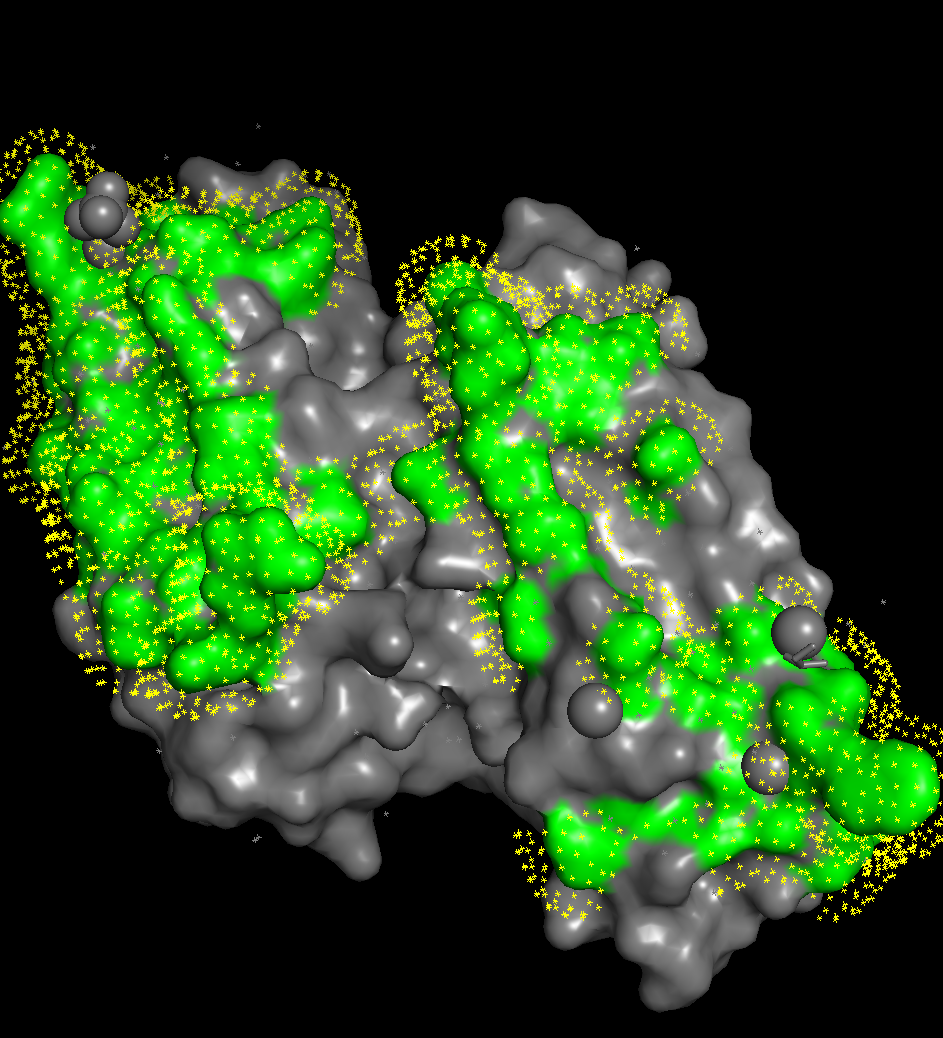

In [12]:
np.concatenate([pocket[0] for pocket in model_predictions_mmcifed['1aiiA']])

array([100, 101, 102, 103, 104, 105, 106, 107, 108, 259, 260, 261, 262,
       263, 264, 265, 266, 267, 277,  73,  26,  27,  28,  29,  30,  31,
        32,  33,  34,  35,  36,  37,  40, 108, 144, 145, 182, 183, 184,
       185, 186, 187, 188, 189, 190, 191, 192, 260, 261, 265, 267,  29,
        30,  32,  33,  34,  36,  68,  69,  70,  71,  72,  73,  74,  75,
        76,  77,  78, 303, 304, 305, 306, 307, 308, 309, 310, 311, 162,
       189, 190, 229, 230, 231, 108, 233, 236, 162, 204, 241, 244, 245,
       224, 112,  15,   3, 147])

In [ ]:
from Bio.PDB.SASA import ShrakeRupley

In [ ]:
import numpy as np

from Bio.PDB import MMCIFParser, PDBParser
from Bio.PDB.SASA import ShrakeRupley

CIF_FILES = '/home/vit/Projects/deeplife-project/data/cif_files'

pdb_id = '1aii'
chain_id = 'A'
protein_id = pdb_id + chain_id
predicted_binding_sites = cryptoshow_utils.map_mmcif_numbering_to_auth(protein_id[:4], protein_id[4:], np.concatenate([pocket[0] for pocket in model_predictions_mmcifed[protein_id]]))

# load structure
p = MMCIFParser(QUIET=1)
struct = p.get_structure("protein", f"{CIF_FILES}/{pdb_id}.cif")
struct = struct[0][chain_id]  # Get first model, chain A

# compute SASA
sr = ShrakeRupley()
sr.compute(struct, level="A")

surface_points = []
map_surface_points_to_atom_id = []
for residue in struct.get_residues():
    # consider only residues from predicted binding sites
    if residue.get_id()[1] not in predicted_binding_sites:
        continue
    for atom in residue.get_atoms():
        surface_points.append(atom.sasa_points)
        map_surface_points_to_atom_id.extend([atom.get_serial_number()] * len(atom.sasa_points))

surface_points = np.vstack(surface_points)
map_surface_points_to_atom_id = np.array(map_surface_points_to_atom_id)
print(surface_points.shape, map_surface_points_to_atom_id.shape)


AttributeError: 'Atom' object has no attribute 'points'

In [44]:
from Bio.PDB import MMCIFParser, PDBParser

from Bio.PDB.SASA import ShrakeRupley
CIF_FILES = '/home/vit/Projects/deeplife-project/data/cif_files'

p = MMCIFParser(QUIET=1)

# This assumes you have a local copy of 1LCD.pdb in a directory called "PDB"

struct = p.get_structure("protein", f"{CIF_FILES}/1aii.cif")
struct = struct[0]['A']  # Get first model, chain A
sr = ShrakeRupley()

sr.compute(struct, level="A")
for i in struct[2].get_atoms():
    print(i.get_serial_number(), i.sasa_points)


KeyError: (' ', 2, ' ')

In [45]:
sr.compute(struct, level="A")
for i in struct[3].get_atoms():
    print(i.get_serial_number(), i.sasa_points)


1 [[  2.02553114 -17.73261076  -5.47450042]
 [  1.22874641 -18.19410336  -5.76950026]
 [  2.71159554 -18.45317054  -5.9465003 ]
 [  0.25676382 -17.79336786  -6.06450033]
 [  1.67059919 -18.93253303  -6.24150038]
 [  3.56889677 -18.43099475  -6.41850042]
 [  0.41893375 -18.64373803  -6.53650045]
 [  2.49405313 -19.2555964   -6.7135005 ]
 [ -0.5049268  -17.59659404  -6.83150041]
 [  1.04358476 -19.32116461  -7.00850034]
 [  3.42724359 -19.12022972  -7.18550038]
 [ -0.25668275 -18.52010763  -7.30350035]
 [  1.9588565  -19.65540457  -7.4805004 ]
 [  4.24245203 -18.55868471  -7.65750045]
 [  0.39668369 -19.2754302   -7.77550042]
 [  2.96424663 -19.56424332  -7.95250043]
 [ -0.71424568 -18.0752666   -8.07050042]
 [  4.76053154 -17.68305898  -8.12950042]
 [  1.32567149 -19.69910574  -8.24750043]
 [  3.85470843 -19.05860424  -8.42450044]
 [ -0.11724222 -18.90764642  -8.54250044]
 [  2.34801942 -19.70364547  -8.71950045]
 [ -0.87750781 -17.46445304  -8.83750045]
 [  4.45444953 -18.2367543   -8.